<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/T_SIS_edges_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# SIR

En esta parte está el código para un SIR usando agrupamiento de nodos. Se agrega la opción $Tuto=True$ para imprimir las acciones del algoritmo Gillespie y presentar los cambios en la gráfica. Se recomienda para gráficas de orden pequeño (e.g. N=10)

In [ ]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True

    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    X_R=0
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo 
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            X_I-=1
            X_R+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo 
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        
        if(X_I==0):
            flag=False
    return Historia

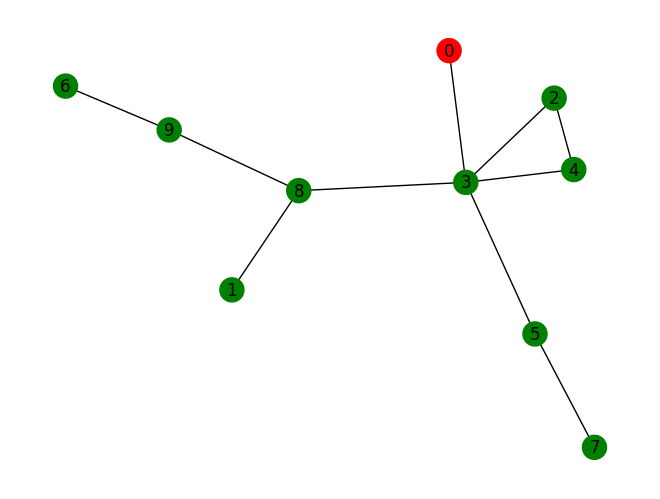

Empieza


In [ ]:
N=10
n=3
G=nx.fast_gnp_random_graph(n=N,p=n/N)
X_I_indexes=[0]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
nx.draw(G_copy,node_color=['green' if G_copy.nodes[i]['Estado:']=='Susceptible' else 'red' if G_copy.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in range(len(list(G_copy.nodes)))],with_labels=True)
plt.show()
print("Empieza")
H=Gillespie_Direct_Method_Network(beta=1.25,gamma=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=np.inf,Tuto=False)

# SIS

Voy a hacer la modificación hacia el SIS, igual de forma gráfica usando $Tuto=True$. Además, se agrega un parámetro times_edges_count que es un arreglo de tiempos en el que se contará el número de conexiones Susceptibles-Infecciosas en la gráfica.

In [ ]:
def Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(len(X_I_indexes)==1):#Se puede acabar
        u_2=0#forzar la infeccion
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación--
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network_SIS(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    counter=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in G_network_initial.nodes():
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    hist_N_SI=[[len(list(G_network_initial.neighbors(X_I_indexes[0]))),1]]
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(int(list(dict_num_contacts.keys())[-1])+1):#Podria no ser continuo? digamos k=0,1,2,5
            k=int(k)
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            #num_cont_inf_por_indice[new_reaction]=0#Una vez que se infecta, ignoramos momentaneamente el número de contactos infecciosos que tenía, pues ya no se puede volver a contagiar.
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo 
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error. Pero ya está arreglado.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)# remove es con busqueda
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:# Paso de infeccioso a susceptible otra vez.
            X_I-=1
            X_S+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Susceptible'
            #------------------ Volvemos a contar sus contactos infecciosos.
            num_cont_inf_por_indice[new_reaction]=0
            for neig in G_network_initial.neighbors(new_reaction):
                if(G_network_initial.nodes[neig]['Estado:']=='Infeccioso'):
                    num_cont_inf_por_indice[new_reaction]+=1
            #-------------------
            X_I_indexes.pop(new_reaction_index)#Lo saca de infecciosos
            #----------------- Lo volvemos a ubicar en susceptibles
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            if(num_cont_inf_por_indice[new_reaction]>num_max_cont):#Si mas de uno crea una categoria, hay error.
                for dif in range(num_max_cont+1,int(num_cont_inf_por_indice[new_reaction]+1)):
                    dict_num_contacts[str(dif)]=[]
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))]=[new_reaction]
            else:
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))].append(new_reaction)
            #-----------------
            i=new_reaction
            #print(i, "es el que se va a recuperar")
            #----------------- Actualizamos el numero de contactos de sus vecinos.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                #print("estoy en el vecino ",vecino," con estatus: ",G_network_initial.nodes[vecino]['Estado:'])
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)#Actualizamos el numero de contactos infecciones en -1
                    #print("lo intento quitar del conjunto de ",num_cont_del_vecino, " vecinos infecciosos. i.e.", dict_num_contacts[str(int(num_cont_del_vecino))])
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion

            #-------------------------------------------
        t+=tau #Actualiza el tiempo 
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        N_SI=0
        for node in G_network_initial.nodes():
            if G_network_initial.nodes[node]['Estado:']=='Susceptible':
                for neig in G_network_initial.neighbors(node):
                    if G_network_initial.nodes[neig]['Estado:']=='Infeccioso':
                        N_SI+=1
        hist_N_SI.append([N_SI,X_I])
        Historia.append([t,X_S,X_I])#Focus
        counter+=1
        if(X_I==0 or t>T):
            flag=False
    return Historia,hist_N_SI

# Exploración del número de aristas promedio vs. la aproximación asumiendo uniformidad de la distribución de infecciosos sobre la gráfica

## Caso 0. Solo para exploración, diferencia entre 
$$N_{SI}(k)=k\frac{N-k}{N}n$$ 
y 
$$\hat{N}_{SI}(k)=k\frac{N-k}{N-1}p(N-1)$$ 


### Caso 0.1 Usando G(N,p), $p\approx 0.1$, N=21. Debería ser parecida a una 2-regular.

In [47]:
N=21
n=2
import time
start_=time.time()
G=nx.gnp_random_graph(n=N,p=0.1)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):#Asegurarme que salga una gráfica conexa
    N=21
    n=2
    G=nx.gnp_random_graph(n=N,p=0.1)
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
X_I_indexes=[0]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.15,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=10000,Tuto=False)
print(len(H))
print("time: ", time.time()-start_)

[0]
Empieza
207750
time:  36.48225259780884


In [48]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
r2=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
    r2.append(i*(N-i)*0.1)
conteo_promedio['approx']=r
conteo_promedio['approx_2']=r2

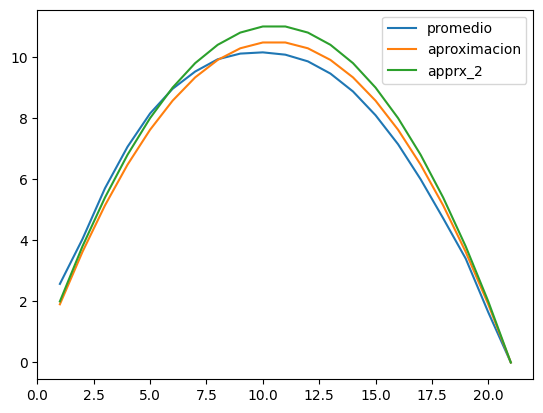

In [49]:
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion','apprx_2'])

### Caso 0.2. Usando una regular estricta. $N=21$, $n=2$

In [54]:
N=21
n=2
import time
start_=time.time()
G=nx.random_regular_graph(d=n,n=N)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):#Asegurarme que salga una gráfica conexa
    N=21
    n=2
    G=nx.random_regular_graph(d=n,n=N)    
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
X_I_indexes=[0]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.15,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=50000,Tuto=False)### 5X más tiempo
print(len(H))
print("time: ", time.time()-start_)

[0]
Empieza
397561
time:  52.721290588378906


In [55]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
r2=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
    r2.append(i*(N-i)*0.1)
conteo_promedio['approx']=r
conteo_promedio['approx_2']=r2

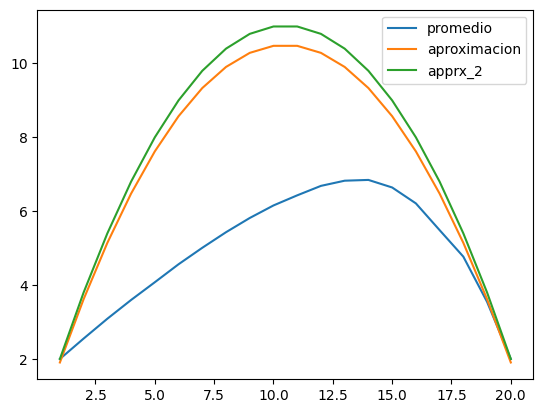

In [56]:
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion','apprx_2'])

## Caso 1. Gráfica 2-regular, de orden $\mathcal{O}(10^3)$.

### Case 1.1. $\beta>>\gamma$ y un único paciente cero. Espero que los infecciosos se extiendan sobre la gráfica más rápidamente y pueda haber 'huecos' entre los clusters de infecciosos que contribuyan al número de aristas S-I

In [ ]:
N=1200
n=2
G=nx.random_regular_graph(n,N)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):#Asegurarme que salga una gráfica conexa
    N=1200
    n=2
    G=nx.random_regular_graph(n,N)
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
X_I_indexes=[list(G.nodes)[0]]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=2.5,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=100,Tuto=False)
print(len(H))

[0]
Empieza
23351


In [ ]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
r2=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
conteo_promedio['approx_2']=r

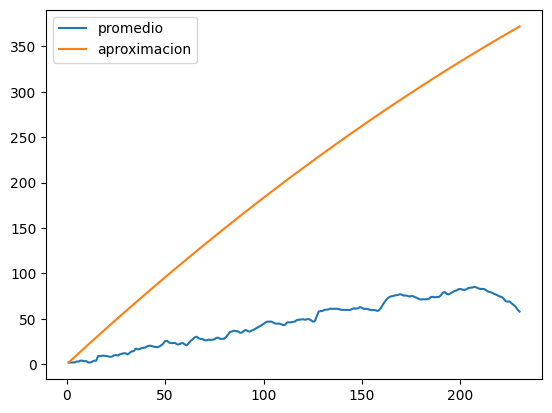

In [ ]:
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])

### Caso 1.2 $\beta=\gamma$ y un único paciente cero. (le agrego más tiempo a la simulación)

In [ ]:
N=1200
n=2
G=nx.random_regular_graph(n,N)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):
    N=1200
    n=2
    G=nx.random_regular_graph(n,N)
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
X_I_indexes=[list(G.nodes)[0]]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=1000,Tuto=False)
print(len(H))

[0]
Empieza
6518


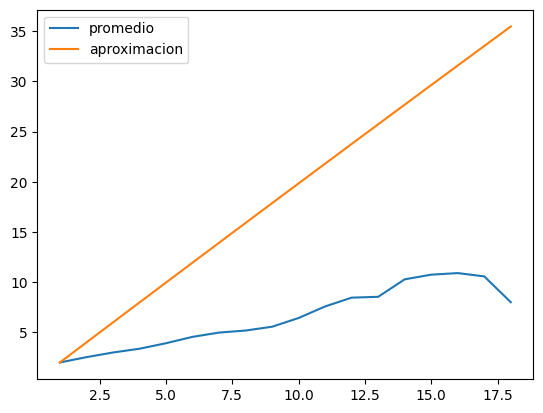

In [ ]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])

### Caso 1.3 $\beta=\gamma$ y hay varios pacientes cero. En este caso, distribuímos los infecciosos al tiempo cero sobre la gráfica de manera aleatoria

In [ ]:
N=1200
n=2
G=nx.random_regular_graph(n,N)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):
    N=1200
    n=2
    G=nx.random_regular_graph(n,N)
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
INF_RND=np.random.choice(N,int(N/2),replace=False)
X_I_indexes=[list(G.nodes)[i] for i in INF_RND]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=200,Tuto=False)
print(len(H))

[870, 647, 376, 358, 275, 520, 159, 131, 465, 935, 156, 1156, 830, 713, 580, 907, 786, 576, 1055, 789, 259, 649, 569, 817, 1079, 280, 663, 1184, 427, 1048, 32, 954, 500, 303, 595, 1172, 1016, 274, 969, 353, 305, 231, 337, 454, 1001, 68, 915, 535, 857, 875, 12, 609, 308, 114, 346, 787, 134, 881, 157, 225, 22, 13, 668, 1064, 4, 341, 614, 977, 445, 1023, 368, 925, 352, 176, 408, 214, 1108, 727, 365, 364, 508, 850, 360, 1118, 477, 818, 14, 63, 29, 171, 538, 118, 292, 410, 685, 887, 903, 1029, 351, 392, 607, 1099, 1059, 750, 162, 573, 348, 680, 1177, 855, 307, 413, 906, 993, 58, 521, 865, 60, 1007, 754, 829, 970, 476, 11, 710, 96, 147, 760, 380, 458, 974, 1072, 243, 745, 872, 123, 1067, 403, 371, 600, 87, 1060, 33, 289, 557, 1119, 415, 1163, 1035, 640, 481, 290, 302, 717, 984, 390, 1093, 3, 1167, 282, 56, 298, 1122, 629, 509, 108, 110, 689, 634, 278, 129, 350, 916, 20, 430, 484, 36, 519, 904, 665, 269, 361, 972, 541, 1019, 731, 189, 692, 897, 840, 211, 469, 763, 567, 686, 618, 502, 109, 105

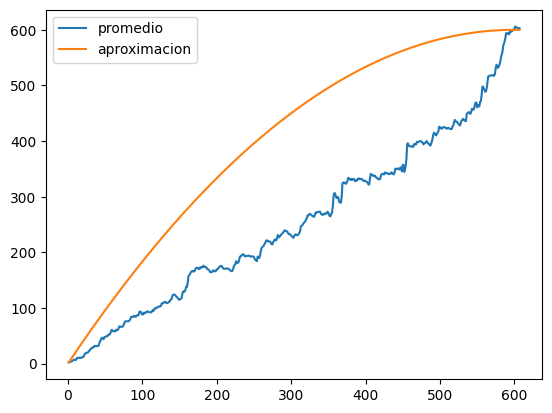

In [ ]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])

### Caso 1.4 El mismo caso pero con mucho tiempo

In [ ]:
N=1200
n=2
G=nx.random_regular_graph(n,N)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):
    N=1200
    n=2
    G=nx.random_regular_graph(n,N)
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
INF_RND=np.random.choice(N,int(N/2),replace=False)
X_I_indexes=[list(G.nodes)[i] for i in INF_RND]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=2000,Tuto=False)
print(len(H))

[247, 342, 1087, 1062, 217, 665, 897, 326, 400, 190, 497, 1015, 1092, 183, 658, 840, 145, 384, 1106, 729, 207, 557, 701, 256, 984, 728, 793, 570, 81, 278, 690, 494, 616, 129, 618, 1048, 202, 272, 286, 101, 228, 274, 1039, 844, 355, 330, 432, 1153, 734, 546, 737, 619, 478, 470, 520, 323, 912, 61, 564, 815, 670, 154, 716, 1169, 731, 270, 229, 585, 1120, 261, 412, 779, 524, 394, 979, 811, 338, 164, 180, 1192, 821, 879, 850, 682, 911, 377, 547, 746, 822, 635, 480, 810, 643, 1060, 666, 663, 922, 291, 798, 745, 491, 458, 774, 1021, 19, 939, 133, 59, 1072, 927, 23, 1061, 1166, 1191, 240, 78, 1091, 597, 45, 644, 24, 715, 1159, 965, 952, 1195, 461, 6, 334, 751, 980, 623, 56, 244, 16, 913, 1119, 1127, 969, 1051, 685, 1047, 723, 645, 974, 1175, 474, 802, 189, 972, 1105, 996, 805, 533, 347, 853, 80, 514, 241, 705, 688, 395, 445, 950, 475, 919, 221, 51, 800, 855, 565, 282, 1081, 791, 845, 849, 104, 259, 536, 234, 501, 255, 653, 74, 368, 71, 165, 1156, 772, 55, 527, 885, 930, 1197, 1041, 122, 289, 1

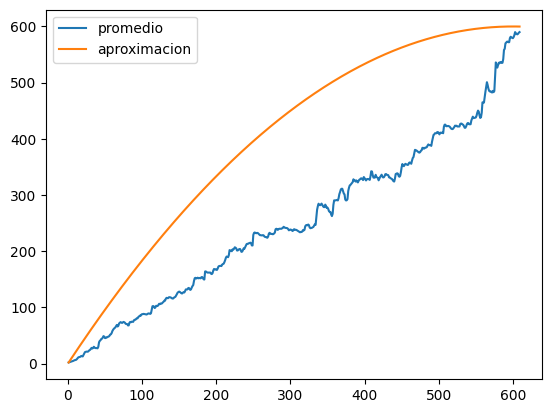

In [ ]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])

## Caso 2. En gráficas G(n,p)

### Caso 2.1. Gráfica G(N,p), N=1200, $p=0.01$.

In [ ]:
N=1200
n=12
G=nx.fast_gnp_random_graph(n=N,p=n/N)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):
    N=N
    n=n
    G=nx.fast_gnp_random_graph(n=N,p=n/N)
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
INF_RND=np.random.choice(N,int(N/2),replace=False)
X_I_indexes=[list(G.nodes)[0]]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=100,Tuto=False)
print(len(H))

[0]
Empieza
218536


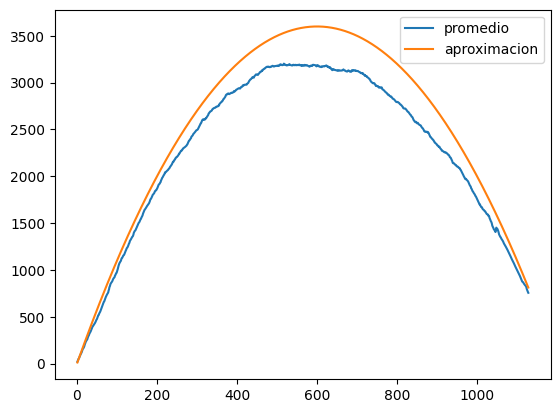

In [ ]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])

#### Nota: Aunque $p\approx 0.01$, ya se ve una buena aproximación. Conjeturo que con más tiempo de simulación, se ve mejor la aproximación.

### Caso 2.2. Hacer $N=\mathcal{O}(10^4)$ y menos tiempo. Dejando $p=0.01$

In [ ]:
N=10**4
n=100
G=nx.fast_gnp_random_graph(n=N,p=0.01)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
X_I_indexes=[list(G.nodes)[0]]
print(nx.is_connected(G)," sea conexa")
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=0.05,Tuto=False)
print(len(H))

True  sea conexa
Empieza
121


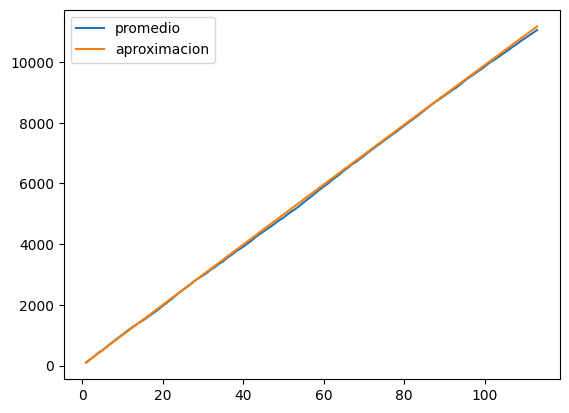

In [ ]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])